In [1]:
import sys
sys.path.append('..')
from mtDNAsim import *

/home/wangkun/mtDNA_simulation/notebook/../mtDNAsim/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import seaborn as sns
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import phylovelo as pv

In [4]:
plt.rcParams['font.size'] = 12

In [77]:
num_elements = 5
system = Gillespie(
    num_elements,
    inits=[1, 0, 0, 0, 0],
    max_cell_num=20000
)

p0 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p1 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p2 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 18))))
p3 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 19))))
p4 = lambda t: (1 - 1 / (1 + np.exp(-0.6 * (t - 20))))
d0 = lambda t: 1 - p0(t)
d1 = lambda t: 1 - p1(t)
d2 = lambda t: 1 - p2(t)
d3 = lambda t: 1 - p3(t)

system.add_reaction(p0, [1, 0, 0, 0, 0], [2, 0, 0, 0, 0], index=0) # 0 self renew
system.add_reaction(p1, [0, 1, 0, 0, 0], [0, 2, 0, 0, 0], index=1) # 1 self renew
system.add_reaction(p2, [0, 0, 1, 0, 0], [0, 0, 2, 0, 0], index=2) # 2 self renew
system.add_reaction(p3, [0, 0, 0, 1, 0], [0, 0, 0, 2, 0], index=3) # 3 self renew
system.add_reaction(p4, [0, 0, 0, 0, 1], [0, 0, 0, 0, 2], index=4) # 4 self renew
system.add_reaction(d0, [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], index=5) # 0 -> 1 differentiation
system.add_reaction(d1, [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], index=6) # 1 -> 2 differentiation
system.add_reaction(d2, [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], index=7) # 2 -> 3 differentiation
system.add_reaction(d3, [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], index=8) # 3 -> 4 differentiation

system.evolute(20000000)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [78]:
cell_num_traj = np.array(system.n)

In [94]:
data_path = "../results/"
tree_file_name = "tree_origin_linear.csv"
cell_num_file_name = "cell_num_linear.csv"

curr_cells = []
t = np.array(system.generation_time)
cell_num_traj = np.array(system.n)

for i in system.curr_cells.values():
    curr_cells += i
# while tree_file_name in os.listdir(data_path):
#     tree_file_name = tree_file_name[:-1] + str(int(tree_file_name[-1]) + 1)
#     cell_num_file_name = cell_num_file_name[:-1] + str(int(cell_num_file_name[-1]) + 1)

np.savetxt(
    data_path + cell_num_file_name,
    np.hstack((t.reshape(-1, 1), cell_num_traj)),
    fmt="%.5f",
)

sim_utils.wirte_lineage_info(
    data_path + tree_file_name, system.anc_cells, curr_cells, system.t[-1]
)

In [95]:
reconstruct('../results/tree_origin_linear.csv', output='../results/linear_tree_gt.nwk', num=5000, is_balance=True)

In [96]:
tree_file = '../results/linear_tree_gt.nwk'
phylo_tree, branch_colors = loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = get_annotation('../results/tree_origin_linear.csv')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [98]:
sd = scData(
    phylo_tree=phylo_tree,
    cell_states=cell_states.to_numpy().T[0].astype('int'),
    cell_generation=cell_generation.T[0].astype('int'),
    cell_names=sampled_cells
)

In [99]:
ge, base_expr = sim_base_expr(sd.phylo_tree,
                                 cell_states,
                                 Ngene=4000,
                                 r_variant_gene=0.4,
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0,
                                 mu0_scale=1,
                                 drift_loc=0,
                                 drift_scale=0.1,
                                )

In [142]:
sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.5)

In [147]:
sd.dimensionality_reduction(method='tsne', perplexity=30)

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


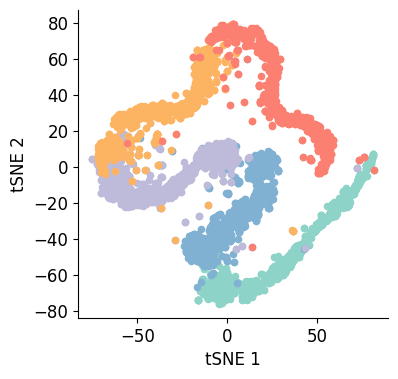

In [148]:
fig, ax = plt.subplots(figsize=(4, 4))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i], s=20)
ax.set_xlabel('tSNE 1', )
ax.set_ylabel('tSNE 2', )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [121]:
sd.count = sd.count[sd.count.columns[sd.count.sum(0)!=0]]

In [ ]:
pv.velocity_inference(sd, sd.cell_generation, cutoff=0.97, target='count')

In [125]:
pv.velocity_embedding(sd, target='count', n_neigh=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

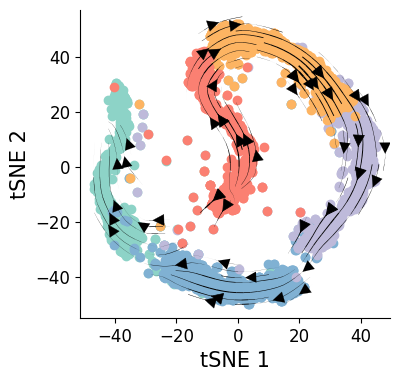

In [128]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i], s=3)
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=25, radius=2, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(4, 4)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

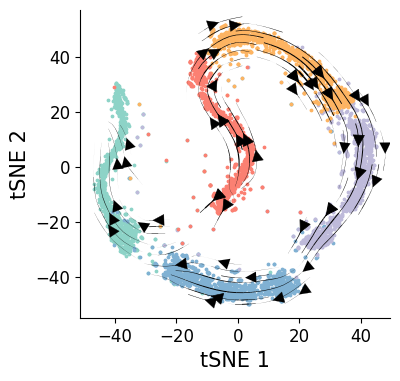

In [130]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i], s=3)
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=25, radius=2, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(4, 4)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [14]:
tree_file = '../results/linear_tree_gt.nwk'
phylo_tree, branch_colors = loadtree(tree_file)

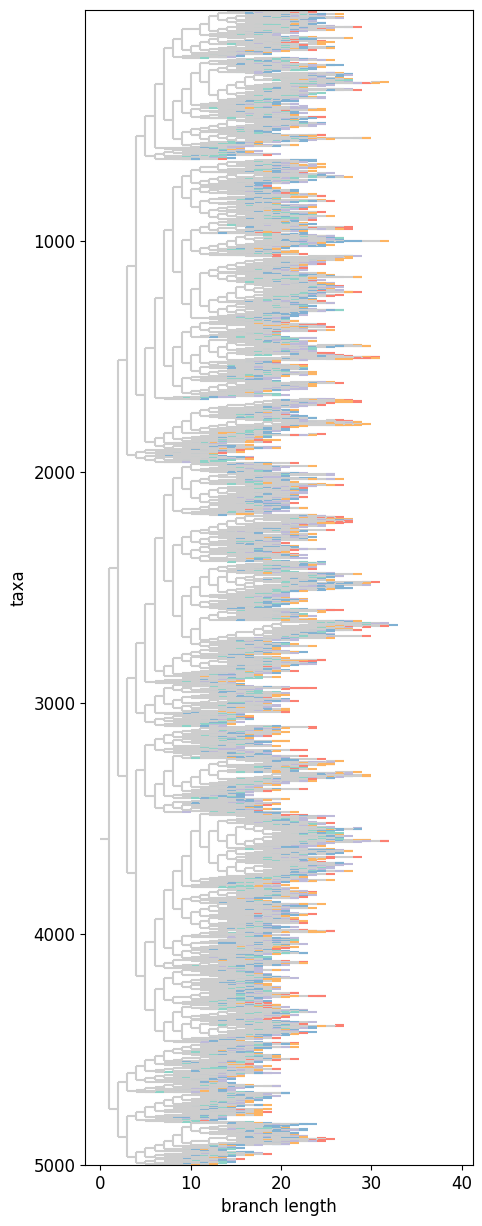

In [15]:
import phylovelo as pv
fig, ax = plt.subplots(figsize=(5,15))
ax = pv.plot_tree(phylo_tree, branch_colors, ax, stain="terminals", colortab=['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072'])

In [19]:
import pickle
pickle.dump(sd, open('../results/sd_linear.pkl', 'wb'))
# sd = pickle.load(open('../results/sd_linear.pkl', 'rb'))

In [20]:
# seqs = DNAmutation(sd.phylo_tree, mut_rate=0.1)

In [347]:
seqs = dna_seq_simulation(sd.phylo_tree, mut_prob=0.001)

  0%|          | 0/6296 [00:00<?, ?it/s]

In [415]:
seqs1 = DNAmutation(sd.phylo_tree, mut_rate=1)

In [129]:
mt_muts, mutid = mtmutation(sd.phylo_tree, nmts=500, mut_rate=0.0016, init_mut_rate=5, mt_copynumber=2)

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/26192 [00:00<?, ?it/s]

In [131]:
pre_existing_mut = set()
for i in mt_muts['<0_0>']:
    pre_existing_mut = pre_existing_mut.union(i)

In [133]:
n_mts = []
for i in sd.Xdr.index:
    n_mts.append(len(mt_muts[i]))

Text(0, 0.5, 'Number of mts')

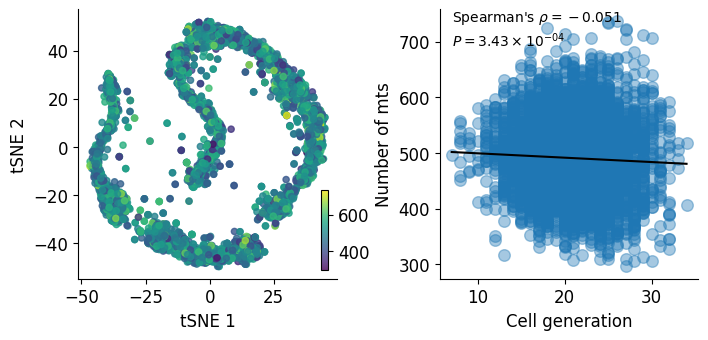

In [134]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
# for i in range(5):
scatter = ax[0].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=n_mts, s=20, alpha=0.8)
ax[0].set_xlabel('tSNE 1', )
ax[0].set_ylabel('tSNE 2', )
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
cbaxes = inset_axes(ax[0], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
pv.corr_plot(sd.cell_generation, n_mts, ax=ax[1], stats='spearman')
# plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
ax[1].set_xlabel('Cell generation')
ax[1].set_ylabel('Number of mts')

In [135]:
mf_leave = mut_freq(mt_muts, mutid, sel_cells=[i.name for i in sd.phylo_tree.get_terminals()])

  0%|          | 0/5000 [00:00<?, ?it/s]

In [136]:
mf_inner = mut_freq(mt_muts, mutid, sel_cells=[i.name for i in sd.phylo_tree.get_nonterminals()])

  0%|          | 0/21192 [00:00<?, ?it/s]

In [137]:
mf_leave.to_csv('../results/mt_constant_mut_freq_leave.csv')

In [138]:
mf_inner.to_csv('../results/mt_constant_mut_freq_inner.csv')

In [43]:
mut_table = mf.astype(bool).astype(int)
with open('../results/mt_constant_mut.phy', 'w') as f:
    f.write('{} {}\n'.format(*mut_table.shape))
    for cell in mut_table.index:
        f.write('{} {}\n'.format(cell[1:-1], ''.join(mut_table.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

In [352]:
with open('../results/dna_constant_mut.phy', 'w') as f:
    f.write('{} {}\n'.format(*seqs.shape))
    for cell in seqs.index:
        f.write('{} {}\n'.format(cell[1:-1], ''.join(seqs.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

In [140]:
sd.Xdr.to_csv('/data3/wangkun/mtsim_res/new/tSNE.csv')

In [233]:
with open('../results/linear_tree_gt.nwk', 'r') as f:
    line = f.readline()
line.replace('\n', ';')
f = StringIO(line)
tree1 = Phylo.read(f, 'newick')

with open('../results/mt_constant_mut_mp.nwk', 'r') as f:
    line = f.readline()
line.replace('\n', ';')
f = StringIO(line)
tree2 = Phylo.read(f, 'newick')

In [234]:
f = StringIO()
Phylo.write(tree1, f, 'newick')
tree1 = Tree(f.getvalue().strip(), format=1)
f = StringIO()
Phylo.write(tree2, f, 'newick')
tree2 = Tree(f.getvalue().strip(), format=1)

In [321]:
from Bio import Phylo
tree_nj = loadtree('../results/mt_constant_mut_nj.nwk')[0]
tree_mp = loadtree('../results/mt_constant_mut_mp.nwk')[0]
tree_gt = loadtree('../results/linear_tree_gt.nwk')[0]
for i in tree_gt.get_terminals():
    i.name = i.name[1:-1]
# tree_ml = Phylo.read('/data3/wangkun/linear.phy.treefile', 'newick')

In [353]:
tree_dna_nj = loadtree('../results/dna_mt_constant_mut_nj.nwk')[0]
tree_dna_mp = loadtree('../results/dna_mt_constant_mut_mp.nwk')[0]

In [336]:
robinson_foulds(tree_gt, tree_mp)

[494, 1994]

In [337]:
robinson_foulds(tree_gt, tree_nj)

[578, 1994]

In [334]:
robinson_foulds(tree_nj, tree_mp)

[602, 1994]

In [354]:
robinson_foulds(tree_gt, tree_dna_mp)

[450, 1994]

In [355]:
robinson_foulds(tree_gt, tree_dna_nj)

[374, 1994]

In [356]:
from itertools import combinations

In [359]:
tree_cmp = pd.DataFrame(index=['GroundTruth', 'mt_MP', 'mt_NJ', 'DNA_MP', 'DNA_NJ'], columns=['GroundTruth', 'mt_MP', 'mt_NJ', 'DNA_MP', 'DNA_NJ'])
for t1, t2 in combinations(zip(['GroundTruth', 'mt_MP', 'mt_NJ', 'DNA_MP', 'DNA_NJ'],[tree_gt, tree_mp, tree_nj, tree_dna_mp, tree_dna_nj]), 2):
    rf = robinson_foulds(t2[1], t1[1])
    tree_cmp[t2[0]][t1[0]] = rf[0]/rf[1]

In [361]:
import seaborn as sns

In [365]:
# tree_cmp[tree_cmp.isna()] = 0

In [380]:
tree_cmp[tree_cmp==0] = np.nan
tree_cmp = tree_cmp.astype(float)

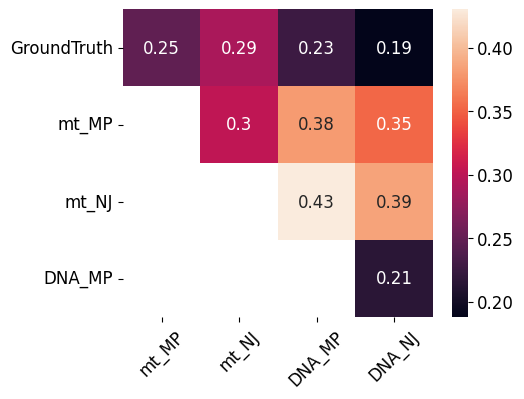

In [392]:
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(tree_cmp.iloc[:-1, 1:], ax=ax, annot=True)
a = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
depths_gt = [len(tree_gt.get_path(tree_gt.find_any(i))) for i in sampled_cells]
depths_mp = [len(tree_mp.get_path(tree_mp.find_any(i[1:-1]))) for i in sampled_cells]
depths_nj = [len(tree_nj.get_path(tree_nj.find_any(i[1:-1]))) for i in sampled_cells]

# tree_depths = tree_nj.depths()
# depths_map = dict()
# for i in tree_depths:
#     depths_map[i.name] = tree_depths[i]
# depths_nj = [depths_map[i[1:-1]] for i in sampled_cells]

# tree_depths = tree_mp.depths()
# depths_map = dict()
# for i in tree_depths:
#     depths_map[i.name] = tree_depths[i]
# depths_mp = [depths_map[i[1:-1]] for i in sampled_cells]

# tree_depths = tree_ml.depths()
# depths_map = dict()
# for i in tree_depths:
#     depths_map[i.name] = tree_depths[i]
# depths_ml = [depths_map[i[1:-1]] for i in sampled_cells]

Text(0, 0.5, 'NJ')

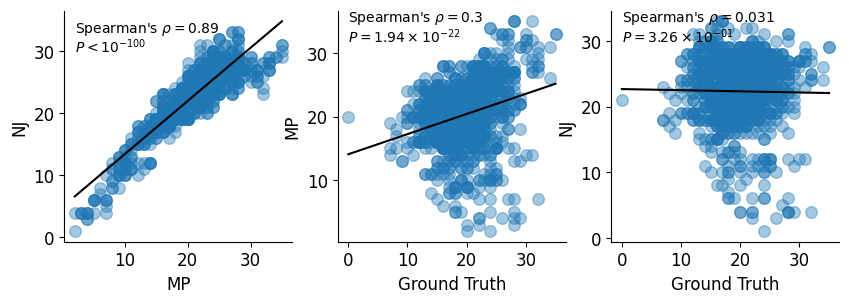

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
pv.corr_plot(depths_mp, depths_nj, ax[0], 'spearman')
pv.corr_plot(depths_gt, depths_mp, ax[1], 'spearman')
pv.corr_plot(depths_gt, depths_nj, ax[2], 'spearman')
ax[0].set_xlabel('MP')
ax[0].set_ylabel('NJ')
ax[1].set_ylabel('MP')
ax[1].set_xlabel('Ground Truth')
ax[2].set_xlabel('Ground Truth')
ax[2].set_ylabel('NJ')

In [88]:
len(pre_existing_mut)

10425

In [90]:
mf[list(set(mf.columns)-pre_existing_mut)].shape

(1000, 6991)

In [68]:
plt.rcParams['font.size'] = 8

In [69]:
mf_unique = mf.T.drop_duplicates(keep='first').T

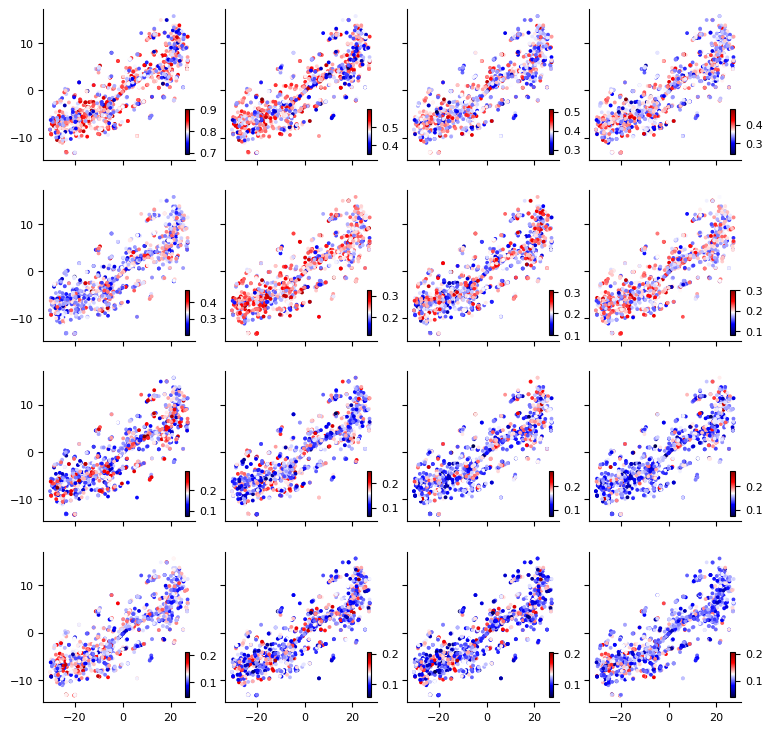

In [70]:
# show_mtmuts = np.random.choice(list(pre_existing_mut), 16, replace=False)
show_mtmuts = mf_unique.sum().sort_values(ascending=False).index[:16]
fig, ax = plt.subplots(4, 4, figsize=(9, 9), sharex=True, sharey=True)
for ind, i in enumerate(show_mtmuts):
    scatter = ax[ind//4][ind%4].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=mf.loc[sd.Xdr.index][i], cmap='seismic', s=3)
    # ax[i//4][i%4].set_xlabel('tSNE 1', )
    # ax[i//4][i%4].set_ylabel('tSNE 2', )
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)
    cbaxes = inset_axes(ax[ind//4][ind%4], width="3%", height="30%", loc='lower right') 
    plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# plt.tight_layout()

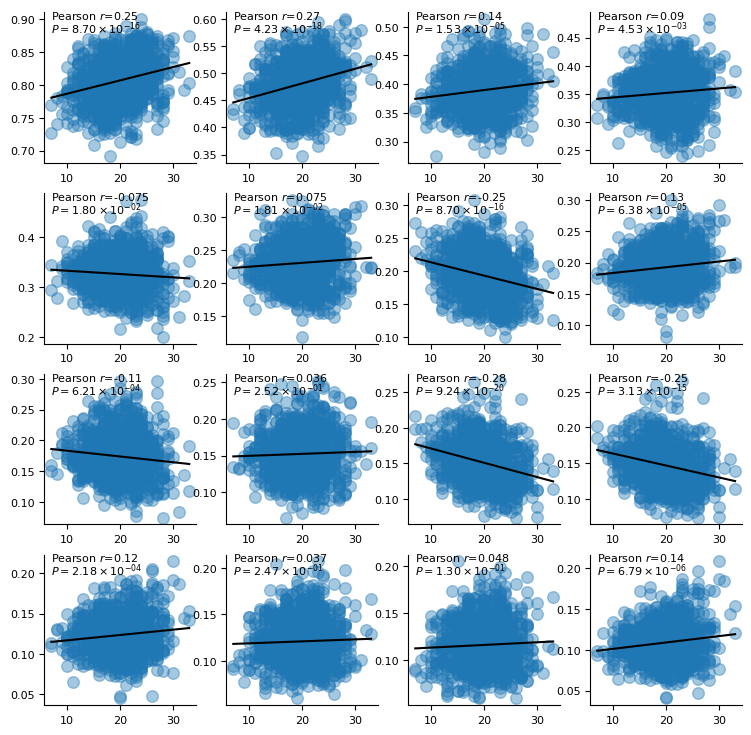

In [71]:
fig, ax = plt.subplots(4, 4, figsize=(9, 9))
for ind, i in enumerate(show_mtmuts):
    pv.corr_plot(sd.cell_generation, mf.loc[sd.Xdr.index][i], ax=ax[ind//4][ind%4], fontsize=8)
    # ax[ind//4][ind%4].scatter(sd.cell_generation, mf.loc[sd.Xdr.index][i], s=3)
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)

# plt.tight_layout()

In [21]:
mf.sum().sort_values(ascending=False).index[:16]

Int64Index([0, 5, 7, 6, 1, 4, 2, 3, 16, 18, 17, 23, 22, 21, 19, 20], dtype='int64')

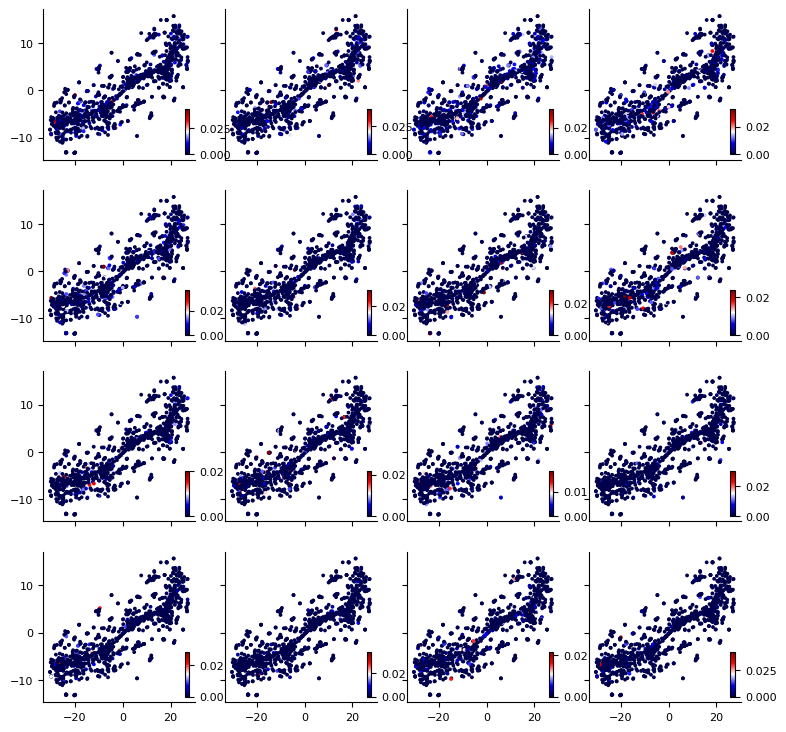

In [23]:
show_mtmuts = mf[list(set(mf.columns)-pre_existing_mut)].sum().sort_values(ascending=False).index[:16]
fig, ax = plt.subplots(4, 4, figsize=(9, 9), sharex=True, sharey=True)
for ind, i in enumerate(show_mtmuts):
    scatter = ax[ind//4][ind%4].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=mf.loc[sd.Xdr.index][i], cmap='seismic', s=3)
    # ax[i//4][i%4].set_xlabel('tSNE 1', )
    # ax[i//4][i%4].set_ylabel('tSNE 2', )
    ax[ind//4][ind%4].spines['right'].set_visible(False)
    ax[ind//4][ind%4].spines['top'].set_visible(False)
    cbaxes = inset_axes(ax[ind//4][ind%4], width="3%", height="30%", loc='lower right') 
    plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# plt.tight_layout()

In [23]:
np.max(mf[list(set(mf.columns)-pre_existing_mut)]).sort_values(ascending=False)

/home/wangkun/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


11112    0.039092
11124    0.038724
42950    0.038298
11108    0.038055
11156    0.037485
           ...   
31460    0.000782
31449    0.000782
31454    0.000782
31383    0.000782
31392    0.000782
Length: 34522, dtype: float64

In [24]:
sum(np.sum(mf[list(set(mf.columns)-pre_existing_mut)]>0.01)!=0)

748

In [25]:
mf[list(set(mf.columns)-pre_existing_mut)].shape

(1000, 34522)

In [26]:
sum(np.sum(mf[list(pre_existing_mut)]>0.01)!=0)

10305

In [27]:
len(pre_existing_mut)

10472

In [46]:
cnt[37]

501

In [72]:
from collections import Counter
cnt = Counter(sum([list(i) for i in mt_muts['<0_0>']], []))

In [73]:
plt.rcParams['font.size'] = 12

Text(0.5, 0, 'Mutation frequency')

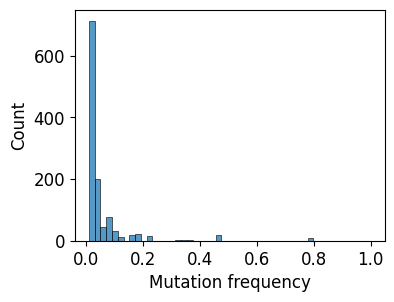

In [74]:
fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(np.array(list(cnt.values()))/len(mt_muts['<0_0>']), bins=np.linspace(0.01 ,1, 50), ax=ax)
ax.set_xlabel('Mutation frequency')

In [75]:
cnt = Counter()
for i in tqdm(sd.phylo_tree.get_terminals()):
    cnt += Counter(sum([list(i) for i in mt_muts[i.name]], []))

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 0, 'Mutation frequency')

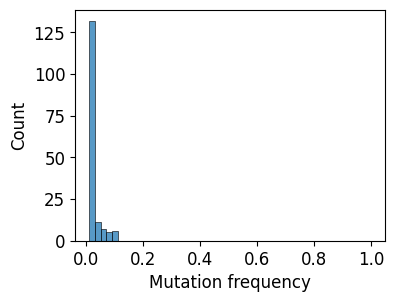

In [40]:
fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(np.array(list(cnt.values()))/sum([len(mt_muts[i]) for i in mt_muts]), bins=np.linspace(0.01 ,1, 50), ax=ax)
ax.set_xlabel('Mutation frequency')